In [66]:
# IMPORTS
##########################

import random
import copy
from keras.models import Sequential
from keras.layers import InputLayer, Dense
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time 
import os, sys
from keras.callbacks import TensorBoard

# Making sure path to SUMO bins correctly specified
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

import sumolib
import traci

In [67]:
# OUTPUT FILE FOLDER
####################################

def get_output_folder(parent_dir, exp_id):
    """Return save folder parent_dir/Results/exp_id
    
    If this directory already exists it creates parent_dir/Results/exp_id_{i}, 
    being i the next smallest free number.
    
    Inside this directory it also creates a sub-directory called model_checkpoints to 
    store intermediate training steps.
    
    This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    
    Parameters
    ----------
    parent_dir : str
        Path of the directory where results will be stored.
    
    Returns
    -------
    parent_dir/Results/exp_id
        Path to this run's save directory.
    """
    try:
        # Returns an error if parent_dir already exists
        os.makedirs(parent_dir)
    except:
        pass
    
    if exp_id in os.listdir(parent_dir):
        
        experiment_id = 1
        new_folder = os.path.join(parent_dir,exp_id+"_"+str(experiment_id))
        
        while os.path.exists(new_folder):
            experiment_id +=1
            new_folder = os.path.join(parent_dir,exp_id+"_"+str(experiment_id))
        
        parent_dir = new_folder
        os.makedirs(parent_dir)
        os.mkdir(os.path.join(parent_dir,"model_checkpoints"))
    else:
        parent_dir = os.path.join(parent_dir,exp_id)
        os.makedirs(parent_dir)
        os.mkdir(os.path.join(parent_dir,"model_checkpoints"))
        
    return parent_dir

In [68]:
# MEMORY CLASS
##################################################

class ReplayMemory():
    """ 
    Keeps a memory of transitions the environment has revealed as response to actions taken.
    
    Keeps a memory of size max_size, implemented through lists of class SingleSample: state, action, reward and nextstate.
    An index counter is pushed forward, through the list as the memory is filled. Once memory is full
    the index starts from 0, and overwrites existing memory. The index counter is also used to indicate
    which one the most recent memory is, to allow prioritising more recent memory over older memory.

    Attributes
    ----------
    memory: (list) list of class SingleSample containing memory of max_size of transitions
    max_size : (int) memory capacity required
    itr : (int) current index
    cur_size : (int) current size of memory
    
    Methods
    ------
    append(state, action, reward, nextstate)
        adds new elements to the four lists, handles index counter
        
    sample(batch_size)
        Randomly draws a sample of batch_size of transitions. It returns 2 arrays and two lists.
        The arrays correspond to state and next state of the transitions with dimensions 
        (batch_size, space_shape).The lists correspond to actions and rewards of those transitions.
        
    print_obs(obs)
        prints a specific transition
        
    get_size
        returns the current size of the memory
    """
    
    def __init__(self, max_size, state_shape, num_actions):
        """Initialize the whole memory at once.
        
        Parameters
        ----------
        max_size : (int) memory capacity required
        state_shape : (tuple) tuple specifying the shape of the array in which state variables are stored.
        num_actions : (int) number of actions (traffic signal phases)
        """
        
        self.memory = [SingleSample(state_shape,num_actions) for _ in range(max_size)]
        self.max_size = max_size
        self.itr = 0  # insert the next element here
        self.cur_size = 0
    
    
    def append(self, state, action, reward, nextstate):
        """Adds new elements to the four lists, handles index counter.
                
        Parameters
        ----------
        state : (np.array) all state variables for one observation
        action : (int) index of the one-hot encoded vector indicating action
        reward : (float) reward after action taken
        nextstate : (np.array) all state variables for one observation, after action taken
        """
        
        self.memory[self.itr].assign(state, action, reward, nextstate)
        self.itr += 1
        self.cur_size = min(self.cur_size + 1, self.max_size)
        self.itr %= self.max_size
        
        
    def sample(self, batch_size):
        """Uniform sampling, later prioritized experience replay can be implemented.
        
        Parameters
        ----------
        batch_size : (int) size of the batch to be sampled
        """

        states, actions, rewards, next_states = [],[],[],[]
        for i, idx in enumerate(np.random.randint(0, self.cur_size, size=batch_size)):
            transition = self.memory[idx]
            states.append(transition.state)
            actions.append(transition.action)
            rewards.append(transition.reward)
            next_states.append(transition.nextstate)
        return np.vstack(states), actions, rewards, np.vstack(next_states)
    
    
    def print_obs(self,obs):
        """Selects a specific transition to view.
        
        Parameters
        ----------
        obs : (int) index of the specific transition to view
        """
        
        self.memory[obs].print_obs() # This calls a SingleSample method called also print_obs

        
    def get_size(self):
        """Shows current size of memory"""
        
        return self.cur_size
    
    
    
class SingleSample():
    """A helper for the memory class. It stores single transition objects.
    
    Attributes
    ----------
    state : (np.array) all state variables for one observation
    action : (int) index of the one-hot encoded vector indicating action
    reward : (int) reward after action taken
    nextstate : (np.array) all state variables for one observation, after action taken
    
    Methods
    -------
    assign(self, state, action, reward, nextstate)
        Assigns new values to attributes.
        
    print_obs()
        Prints current observation/ transition.
    """
    
    def __init__(self, state_shape, num_actions): # Num actions not used up to now
        """Initialises object instance.
        Parameters
        ----------
        state_shape : (tuple) (tuple) tuple specifying the shape of the array in which state variables are stored.
        num_actions : (int) number of actions (traffic signal phases)
        """
        
        self.state = np.zeros(state_shape)
        self.action = 0
        self.reward = 0
        self.nextstate = np.zeros(state_shape)
        
        
    def assign(self, state, action, reward, nextstate):
        """Assigns new values to attributes.
        
        Parameters
        ----------
        state : (np.array) all state variables for one observation
        action : (np.array) index of the one-hot encoded vector indicating action
        reward : (int) reward after action taken
        nextstate : (np.array) all state variables for one observation, after action taken
        """
        
        self.state[:] = state
        self.action = action
        self.reward = reward
        self.nextstate[:] = nextstate
        
        
    def print_obs(self):
        """Prints current observation"""
        
        print( "State: \n\n",self.state,
               "\n\nAction:\n\n",self.action,
               "\n\nReward:\n\n",self.reward,
               "\n\nNext State:\n\n",self.nextstate)

In [69]:
# ROUTING (DEMAND)
#################################################

### TO DO
# Create a class to specify different types of demand

def generate_routefile():
    """Returns XML file specifying network layout for sumo simulation"""
    random.seed(42)  # make tests reproducible
    N = 3600  # number of time steps
    # demand per second from different directions

    pEW = 1 / 20
    pNS = 1 / 80
    pWE = 1 / 20
    pSN = 1 / 80

    with open("cross.rou.xml", "w") as routes:
        print("""<routes>
        <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="16.67" guiShape="passenger"/>
        <route id="right" edges="51o 1i 2o 52i" />
        <route id="left" edges="52o 2i 1o 51i" />
        <route id="down" edges="54o 4i 3o 53i" />
        <route id="up" edges="53o 3i 4o 54i" />""", file=routes)
        vehNr = 0
        for i in range(N):
            if random.uniform(0, 1) < pWE:
                print('    <vehicle id="right_%i" type="car" route="right" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pEW:
                print('    <vehicle id="left_%i" type="car" route="left" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pNS:
                print('    <vehicle id="down_%i" type="car" route="up" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pSN:
                print('    <vehicle id="UP_%i" type="car" route="down" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
        print("</routes>", file=routes)

In [70]:
# Q NETWORKS
################################

# More ANN arquitectures to be specified here
def get_model(model_name, *args):
    """Helper function to instantiate q-networks.
    
    Parameters
    ----------
    model_name : (str) Name of the network architecture to be used to instantiate q-network
    *args : arguments to be passed onto helper functions
    """
    
    if model_name == 'linear':
        return linear(*args)
    elif model_name == 'simple':
        return simple(*args)
    else:
        raise ValueError()

        
def linear(input_shape, num_actions):
    """Feeds into get_model. Sets up a linear keras model instance.
    
    Parameters
    ----------
    input_shape : (np.array) shape of the state vector to be fed into the model as input layer
    num_actions : (int) number of nodes of the output layer
    """
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape, name="Layer_1")) # If a vector the flattening does not have any effect. (only matrices)
    model.add(Dense(num_actions,activation=None, name = "Output"))
    return model


def simple(input_shape, num_actions):
    """Feeds into get_model. Sets up a neural network keras model instance.
        
    Parameters
    ----------
    input_shape : (np.array) shape of the state vector to be fed into the model as input layer
    num_actions : (int) number of nodes of the output layer
    """
    
    model = Sequential()
    model.add(Dense(9, input_shape = input_shape, activation='relu',name = "Layer_1"))
    model.add(Dense(9, activation='relu', name= "Layer_2"))
    model.add(Dense(num_actions, activation=None, name= "Output"))
    return model     

In [98]:
# ENVIRONMENT CLASS
##################################   
class Env:
    """Main class to manage environment. Supplies the environment responses to actions taken.
    
    Sends commands to sumo to take an action, receives state information,
    computes rewards. Does so step by step to allow q-network to train batch-wise.
    
    Attributes
    ----------
    net : (str) points to the SUMO .net.xml file which specifies network arquitechture
    route : (str) points to the SUMO .rou.xml file which specified traffic demand
    use_gui : (bool) Whether to run SUMO simulation with GUI visualisation
    time_step : (int) Simulation seconds between actions
    sumo_binary : (str) Points to the binary to run sumo
    num_actions : (int) number of actions (traffic signal phases)
    
    Methods
    -------
    start_simulation()
        Opens call to sumo
    
    take_action(action)
        Sets the traffic lights according to the action fed as argument

    compute_reward(state, next_state)
        Takes the current state and next state (from object state) and computes reward

    step(action)
        Combines take_action, compute_reward and update_state (from observation object)

    done()
        checks whether all links are empty, and hence the simulation done

    stop_simulation()
        closes the sumo/traci call
    """
    
    def __init__(self,
                 net_file, 
                 route_file,
                 state_shape,
                 num_actions,
                 use_gui = False,
                 delta_time=10):
        """Initialises object instance.
        
        Parameters
        ----------
        net_file : (str) SUMO .net.xml file
        route_file : (str) SUMO .rou.xml file
        state_shape : (np.array) 2-dimensional array specifying state space dimensions
        num_actions : (int) specifying the number of actions available
        use_gui : (bool) Whether to run SUMO simulation with GUI visualisation
        delta_time : (int) Simulation seconds between actions
        """
        
        self.net = net_file
        self.route = route_file
        self.use_gui = use_gui
        self.time_step = delta_time
        self.input_lanes = ["4i_0","2i_0","3i_0","1i_0"] 
        
        if self.use_gui:
            self.sumo_binary = sumolib.checkBinary('sumo-gui')
        else:
            self.sumo_binary = sumolib.checkBinary('sumo')
            
        self.obs = Observation(state_shape, self.input_lanes)
        self.action = Action(num_actions)
        
        
        self.counter = np.zeros((1,2))
 

    def start_simulation(self):
        """Opens a connection to sumo/traci [with or without GUI] and 
        updates obs atribute  (the current state of the environment).
        """
    
        sumo_cmd = [self.sumo_binary, 
                    '-n', self.net,
                    '-r' ,self.route]
        
        if self.use_gui:
            sumo_cmd.append('--start')
        traci.start(sumo_cmd)
        self.obs.update_state()
        
        
    def take_action(self,action):
        """Sets the action variable in sumo/traci to a new value.
        
        Parameters
        ----------
        action : (int) index of the one-hot encoded vector of action to be taken
        """
        
        #action = 0 -> row vertically
        if action == 0 and traci.trafficlight.getPhase("0") != 0:
            traci.trafficlight.setPhase("0",3)
            self.counter += self.obs.get()[:,-2:]
            self.obs.get()[:,-2:] = 0
        #action = 1 -> row horizontally    
        elif action == 1 and traci.trafficlight.getPhase("0") != 2:
            traci.trafficlight.setPhase("0",1)
            self.counter += self.obs.get()[:,-2:]
            self.obs.get()[:,-2:] = 0
                
    def compute_reward(self, state, next_state):
        """ Computes reward from state and next_state.
        
        Parameters
        ----------
        state : (np.array) vector of current state
        next_state: (np.array) vector of next state
        """
            
        # Here is whre reward is specified
        a = next_state - state
        b = np.round(state,decimals=1)

        aux = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
        
        return -np.sum(a) #-np.sum(next_state[0,:4])#np.sum(a[0,4:-1])-np.sum(a[0,:4]) # - delta number of stopped cars
        
    def compute_waiting_time(self):
        aux= []
        for lane in self.input_lanes:
            aux.append(traci.lane.getWaitingTime(lane))
        
        return aux         
        
        
    def step(self, action):
        """ Runs one step of the simulation.
        
        Makes a deep copy of the current state,
        runs the simulation with the currently set action,
        gets the state after the action,
        and computes the reward associated to action taken.
        
        Parameters
        ----------
        action : (int) index of the one-hot encoded vector of action to be taken
        """
        
        state = copy.deepcopy(self.obs.get())
        wt = self.compute_waiting_time()
        
        if action != None:
            self.take_action(action)
        
        traci.simulationStep(traci.simulation.getTime() + self.time_step) # Run the simulation time_step (s)
        
        self.obs.update_state()
        next_state = self.obs.get()
        
        wt_next = self.compute_waiting_time()
        reward = self.compute_reward(np.array(wt),np.array(wt_next))
        
        return state, reward, next_state, self.done()
    

            
    
    
    def done(self):
        """Calls sumo/traci to check whether there are still cars in the network"""
        
        return traci.simulation.getMinExpectedNumber() == 0
    
    
    def stop_simulation(self):
        """Closes the sumo/traci connection"""
        
        traci.close()
        

    
class Observation:
    """
    Helper class for environment. Handles the updating of the state. Ports the state from sumo/traci to python.
    
    Attributes
    ----------
    obs : (np.array) holds the state variables
    
    Methods
    -------
    update_state() 
        reads the state through a call to sumo/traci
            --> modify here to include additional state variables, 
            but make sure to also modify state_shape when running the simulation!
            
    get()
        returns state
        
    get_reward()
        returns reward, computed from current state
    """
    
    def __init__(self, shape,lanes):
        """
        Parameters
        ----------
        shape : (tuple) specifying dimensionality of state vector
        """
        
        self.obs = np.zeros(shape)
        self.lanes = lanes
        
        
    def update_state(self):
        """
        Parameters
        ----------
        lanes : (list) hardcoded list of lanes in network
        # TODO: read this from network file
        """
                 
        for i,lane in enumerate(self.lanes):

            self.obs[:,i] = traci.lane.getLastStepOccupancy(lane)
            self.obs[:,i+4] = traci.lane.getLastStepMeanSpeed(lane)
            
        self.obs[:,8] = traci.trafficlight.getPhase("0")
        if self.obs[:,8] == 0:
            self.obs[:,9] = traci.trafficlight.getPhaseDuration("0") - (traci.trafficlight.getNextSwitch("0") - traci.simulation.getTime())
        elif self.obs[:,8] == 2:
            self.obs[:,10] = traci.trafficlight.getPhaseDuration("0") - (traci.trafficlight.getNextSwitch("0") - traci.simulation.getTime())
        
        
        
    def get(self):
        """Returns state vector"""
        
        return self.obs
        
        
#     def get_reward(self):
#         """compute reward corresponding to current state"""
        
#         return -np.sum(self.obs[0:4])
    
    
    
class Action:
    """
    Helper class for observation. One-hot encoding of the phase of the traffic signal. 
    The methods for this class handle the selection of the best action.
    
    Methods
    -------
    select_action(policy, **kwargs)
        Takes policy as argument, and then calls the corresponding method.
        # TODO: assert that the kwargs being fed correspond to the policy selected,
        and handle errors

    select_rand()
        Select one of the actions randomly.
    
    select_greedy(q-values)
        Check which action corresponds to the highest predicted reward/q-value.
    
    select_epsgreedy(eps, q_values)
        Choose whether to explore or exploit.
    """
    
    def __init__( self, num_actions):
        
        self.num_actions = num_actions
        self.action_space = np.identity(num_actions)
        
        
    def select_action(self, policy, **kwargs):
        """Takes policy as argument, and then calls the corresponding helper method.
        
        Parameters
        ----------
        policy : (string) indicating which policy to consider. 
            Currently implemented: 
                - Pick action randomly ("rand")
                - Pick action greedely ("greedy")
                - Pick action in a eps - greedy fashion ("epsGreedy")
                                    
        **kwargs : arguments for helper methods
        """
        
        if policy == "randUni":
            return self.select_rand()
        elif policy == "greedy":
            return self.select_greedy(**kwargs)
        elif policy == "epsGreedy":
            return self.select_epsgreedy(**kwargs)
    
    
    def select_rand(self):
        """Feeds into select_greedy or directly into select_action method.
        Selects one of the actions randomly."""
        
        return np.random.randint(0, self.num_actions)
    
    
    def select_greedy(self, q_values):
        """Feeds into select_epsgreedy or directly into select_action method.
        Checks which action corresponds to the highest predicted reward/q-value.
        
        Parameters
        ----------
        q_values : (np.array) predicted q-values
        """
        
        return np.argmax(q_values)
    
    
    def select_epsgreedy(self, eps, q_values):
        """Feeds into select_action method.
        If explore, select action randomly,
        if exploit, select action greedily using the predicted q values
        
        Parameters
        ----------
        eps : (int) exploration paramter
        q_values : (np.array) predicted q-values
        """
        
        if np.random.uniform() < eps:
            return self.select_rand()
        else:
            return self.select_greedy(q_values)


In [588]:
# DOUBLE DQN
################################

SAVE_AFTER = 11000 # Save model checkpoint
STORE_LOGS_AFTER = 100

class DoubleDQN:
    """The DQN agent. Handles the updating of q-networks, takes action, and gets environment response.
    
    Attributes
    ----------
    q_network : keras model instance to predict q-values for current state
    target_q_network : keras model instance to predict q-values for state after action
    memory : memory instance - needs to be instantiated first # should this be instantiated here?
    gamma : (int) discount factor for rewards
    target_update_freq : (int) defines after how many steps the q-network should be re-trained
    num_burn_in : (int) defines the size of the replay memory to be filled before, using a specified policy 
    batch_size : (int) size of batches to be used to train models
    trained_episodes : (int) episode counter
    max_ep_len : (int) stops simulation after specified number of episodes
    output_dir : (str) directory to write tensorboard log and model checkpoints
    experiment_id : (str) ID of simulation
    summary_writer : tensorboard summary stat writer instance
    itr : (int) counts global training steps in all run episodes
        
    Methods
    -------
    __compile()
        Initialisation method, using the keras instance compile method.
        
    fill_replay()
        Helper method for train. Fills the memory before model training begins.
        
    predict_q()
        Helper method for train. Calls keras predict function using the keras model instance.
    
    save()
        Calls keras save method using the keras model instance.
    
    update_network(env, policy)
        Helper method for train. Computes keras neural network updates using samples from memory.
        
    train(env, num_episodes, policy, **kwargs)
        Main method for the agent. Trains the keras neural network instances, calls all other helper methods.
    
    evaluate(env)
        Use trained agent to run a simulation without training.
    """
    
    def __init__(self,
                 q_network, 
                 target_q_network,
                 memory,
                 gamma, 
                 target_update_freq,
                 num_burn_in,
                 batch_size,
                 optimizer,
                 loss_func,
                 max_ep_length,
                 env_name,
                 output_dir,
                 experiment_id,
                 summary_writer,
                 model_checkpoint = True,
                 opt_metric = None # Used to judge the performance of the ANN
                 ): 
        """    
        # TODO: specify defaults for required arguments
        
        Parameters
        ----------
        """
        self.q_network = q_network
        self.target_q_network = target_q_network
        self.target_q_network.set_weights(self.q_network.get_weights())
        self.__compile(optimizer, loss_func,opt_metric)
        self.memory = memory
        #self.policy = policy
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.num_burn_in = num_burn_in
        self.batch_size = batch_size
        self.trained_episodes = 0
        self.max_ep_len = max_ep_length
        self.output_dir = output_dir
        self.experiment_id = experiment_id
        self.summary_writer=summary_writer
        self.itr = 0
        
        #self.learning_type = learning_type
        
    
    def __compile(self, optimizer, loss_func, opt_metric):
        """Initialisation method, using the keras instance compile method. """
        
        self.q_network.compile(optimizer, loss_func, opt_metric)
        self.target_q_network.compile(optimizer, loss_func, opt_metric)
        
        
    def fill_replay(self, env, policy):
        """Helper method for train. Fills the memory before model training begins.
        
        Parameters
        ----------
        env :  environment instance
        policy : (str) policy to be used to fill memory
        """
        
        print("Filling experience replay memory...")
        
        env.start_simulation()
        
        for i in range(self.num_burn_in):
            action = env.action.select_action(policy)
            state, reward, nextstate, done = env.step(action)
            self.memory.append(state, action, reward, nextstate)
            
        env.stop_simulation()
        
        print("...Done")
    
    
    def predict_q(self, network, state):
        """Helper method for train. Calls keras predict function using the keras model instance."""
        
        return network.predict(state)
    
    
    def save(self):
        """Calls keras save function using the keras model instance"""
        
        filename =  "{}/model_checkpoints/run{}_iter{}.h5" .format(self.output_dir, 
                                               self.experiment_id, 
                                               self.itr)
        self.q_network.save(filename)
        
        
    def named_logs(self, q_network, logs):
        """create logs"""
        
        result = {}
        for l in zip(q_network.metrics_names, logs):
            result[l[0]] = l[1]
        
        return result
    
    
    def update_network(self):
        """Helper method for train. Computes keras neural network updates using samples from memory.
        
        Notice that we want to incur in loss in the actions that we have selected.
        Q_target and Q are set equal for not relevant actions so the loss is 0. 
        (weights not being updated due to these actions)"""
        
        # Sample mini batch
        states_m, actions_m, rewards_m, states_m_p = self.memory.sample(self.batch_size)
        
        # attach q-values to states
        target_batch = self.q_network.predict(states_m) 
        target_q = self.target_q_network.predict(states_m_p)
        
        # choose action
        selected_actions = np.argmax(target_q, axis=1)
        
        # update q-values
        for i, action in enumerate(selected_actions):
            target_batch[i, action] =  rewards_m[i] + self.gamma * target_q[i, action]
        
        # keras method to train on batch that returns loss
        loss = self.q_network.train_on_batch(states_m, target_batch)
        
        # get weights
        weights = self.q_network.get_weights()
        
        # Update weights every target_update_freq steps
        if self.itr % self.target_update_freq == 0:
            self.target_q_network.set_weights(weights)
        
        # Save network every save_after iterations if monitoring allowed
        if self.output_dir and self.itr % SAVE_AFTER == 0:
            self.save()
                
        return loss
    
    
    def histo_summary(self, values, bins=1000):
        """Helper function in train method. Log a histogram of the tensor of values for tensorboard.
        
        Creates a HistogramProto instance that can be fed into Tensorboard.
        
        Parameters
        ---------
        values :  (np.array) histogram values
        bins : (int) how coarse the histogram is supposed to be
        """

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins = bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)
            
        return hist
         
        
    def train(self, env, num_episodes, policy, **kwargs):
        """Main method for the agent. Trains the keras neural network instances, calls all other helper methods.
        
        Parameters
        ----------
        env: (str) name of environment instance
        num_episodes: (int) number of training episodes
        policy: (str) name of policy to use to fill memory initially
        """
        
        all_stats = []
        all_rewards = []
        start_train_ep = self.trained_episodes
        
        for i in range(num_episodes):
            # print progress of training
            sys.stdout.write("\r"+'Running episode {} / {}'.format(self.trained_episodes+1, 
                                                       start_train_ep + num_episodes))
            
            env.start_simulation()
            nextstate = env.obs.get()
            done = False
            
            stats = {
                'ep_id' : self.trained_episodes,
                'total_reward': 0,
                'episode_length': 0,
                'max_q_value': 0, 
            }
            
            while not done and stats["episode_length"] < self.max_ep_len:
                
                q_values = self.q_network.predict(nextstate)
                action = env.action.select_action(policy, q_values = q_values, eps = eps)
                state, reward, nextstate, done = env.step(action)
                self.memory.append(state, action, reward, nextstate)
                
                # Update network weights and record loss for Tensorboard
                loss = self.update_network()
                
                
                if self.output_dir and self.itr % STORE_LOGS_AFTER == 0:
                    # create list of stats for Tensorboard, add scalars
                    summary_list = [tf.Summary.Value(tag = 'loss',
                                                      simple_value = loss),
                                    tf.Summary.Value(tag = 'Action 1',
                                                      simple_value = self.q_network.layers[-1].get_weights()[1][0]),
                                    tf.Summary.Value(tag = 'Action 2',
                                                      simple_value = self.q_network.layers[-1].get_weights()[1][1]),
                                    tf.Summary.Value(tag = 'Episode Length',
                                                      simple_value = stats["episode_length"])]

                    # add histogram of weights to list of stats for Tensorboard
                    for index, layer in enumerate(self.q_network.layers): 

                        if index != len(self.q_network.layers) - 1:
                            summary_list.append(tf.Summary.Value(tag = str(layer.name) + " weights" ,
                                                            histo = self.histo_summary(layer.get_weights()[0])))
                            if len(layer.get_weights()) > 1:
                                summary_list.append(tf.Summary.Value(tag = str(layer.name) + " relu" ,
                                                            histo = self.histo_summary(layer.get_weights()[1])))

                        else:
                            summary_list.append(tf.Summary.Value(tag = str(layer.name) + " output weights" ,
                                                            histo = self.histo_summary(layer.get_weights()[0])))
                            summary_list.append(tf.Summary.Value(tag = "output values",
                                                            histo = self.histo_summary(layer.get_weights()[1])))

                    # write the list of stats to the logdd
                    self.summary_writer.add_summary(tf.Summary(value = summary_list), global_step=self.itr)
                
                self.itr += 1
                
                stats["ep_id"] = self.trained_episodes
                stats["episode_length"] += 1
                stats['total_reward'] += reward
                stats['max_q_value'] += max(q_values)
            
            env.stop_simulation()
            self.trained_episodes += 1
        
            all_stats.append(stats)
            all_rewards.append(stats['total_reward'])
            
        print('\nCurrent reward mean+std: {} {}'.format(np.mean(stats['total_reward']),np.std(stats['total_reward'])))
        return stats
        
    def evaluate(self, env,static):
        """Use trained agent to run a simulation.
        
        Parameters
        ----------
        env : environment instance
        static : (bool) If the static policy is being evaluated
        """
            
        env.start_simulation()
        nextstate = env.obs.get()
        done = False
        it = 0
            
        while not done and it < self.max_ep_len:
            
            if not static:
                q_values = self.q_network.predict(nextstate)
                action = env.action.select_action("greedy", q_values = q_values)
                state, reward, nextstate,done = env.step(action)
            else:
                state, reward, nextstate,done = env.step(None)
            it +=1
                
        env.stop_simulation()
        
        return it
  

In [589]:
# MAIN
##################################

num_actions = 2
state_shape = (1,11) # State var in rows
memory_size = 100000
gamma = 0.8
target_update_frequency = 100
num_init_samples_mem = 1000
batch_size = 50
max_episode_length = 100000
optimizer = 'adam'
loss = "mse"
eps = 0.2
env_name = "Simple_Cross"
experiment_id = "Reward_Waiting_Time"
monitoring = True # Store variables for TensorBoard monitoring and model_checkpoints



# Define logs directory if monitoring enabled
if monitoring: 
    output_dir = get_output_folder("./Logs",experiment_id)
    summary_writer = tf.summary.FileWriter(logdir=output_dir)
else:
    output_dir = None
    summary_writer = None


# Initialize Q-networks (value and target)
q_network = get_model('simple',(state_shape[1],),num_actions)
target_q_network = get_model('simple',(state_shape[1],),num_actions)

# Initialize environment
sumo_env =  Env(    "cross.net.xml",
                    "cross.rou.xml",
                    state_shape,
                    num_actions,
                    use_gui=False
               )

# Initialize replay memory
memory = ReplayMemory(    memory_size,
                          state_shape,
                          num_actions
                     )

# Initialize Double DQN algorithm
ddqn = DoubleDQN(   q_network,
                    target_q_network,
                    memory,
                    gamma,
                    target_update_frequency,
                    num_init_samples_mem,
                    batch_size,
                    optimizer,
                    loss,
                    max_episode_length,
                    sumo_env,
                    output_dir,
                    experiment_id,
                    summary_writer
                )

# Fill Replay Memory
ddqn.fill_replay(sumo_env,'rand')

# Trains Double DQN
num_ep = 200
all_stats = []
static_it = []
static_it_perfect = []
for i in range(num_ep):
    
    generate_routefile()
    
    # Training
    
    static = False
    sumo_env =  Env("cross.net.xml",
                    "cross.rou.xml",
                    state_shape,
                    num_actions,
                    use_gui=False
               )
    all_stats.append(ddqn.train(  sumo_env, 1, "epsGreedy", eps=eps))
    
    # Imperfect static
    
    sumo_env =  Env("cross_no_RL.net.xml",
                "cross.rou.xml",
                state_shape,
                num_actions,
                use_gui=False
           )
      
    static = True
    static_it.append(ddqn.evaluate(sumo_env,static))
    
    # Perfect static
    sumo_env =  Env("cross_no_RL_perfect.net.xml",
                "cross.rou.xml",
                state_shape,
                num_actions,
                use_gui=False
           )
      
    static_it_perfect.append(ddqn.evaluate(sumo_env,static))

#### How to start a Tensorboard
# run the below command in terminal to start Tensorboard, then open http://localhost:6006/ in a browser
# !tensorboard --logdir=./Scripts/Tests_Sumo/cross_RL/Logs

Filling experience replay memory...
...Done
Running episode 1 / 1
Current reward mean+std: 0.0 0.0
Running episode 2 / 2
Current reward mean+std: 0.0 0.0
Running episode 3 / 3
Current reward mean+std: 0.0 0.0
Running episode 4 / 4
Current reward mean+std: 0.0 0.0
Running episode 5 / 5
Current reward mean+std: 0.0 0.0
Running episode 6 / 6
Current reward mean+std: 0.0 0.0
Running episode 7 / 7
Current reward mean+std: 0.0 0.0
Running episode 8 / 8
Current reward mean+std: 0.0 0.0
Running episode 9 / 9
Current reward mean+std: 0.0 0.0
Running episode 10 / 10
Current reward mean+std: 0.0 0.0
Running episode 11 / 11
Current reward mean+std: 0.0 0.0
Running episode 12 / 12
Current reward mean+std: 0.0 0.0
Running episode 13 / 13
Current reward mean+std: 0.0 0.0
Running episode 14 / 14
Current reward mean+std: 0.0 0.0
Running episode 15 / 15
Current reward mean+std: 0.0 0.0
Running episode 16 / 16
Current reward mean+std: 0.0 0.0
Running episode 17 / 17
Current reward mean+std: 0.0 0.0
Runni

KeyboardInterrupt: 

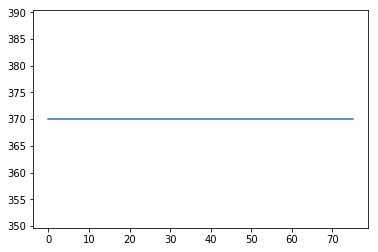

In [592]:
import pandas as pd
all_stats2 = pd.DataFrame(all_stats)
#plt.plot(np.arange(len(all_stats2["episode_length"])),all_stats2["episode_length"])
plt.plot(np.arange(len(static_it)),static_it)
plt.plot(np.arange(len(static_it_perfect)),static_it_perfect)

In [113]:
# Evaluates Double DQN
sumo_env =  Env(    "cross.net.xml",
                    "cross.rou.xml",
                    state_shape,
                    num_actions,
                    use_gui=True
               )
#ddqn.evaluate( sumo_env)

In [114]:
sumo_env.start_simulation()
nextstate = sumo_env.obs.get()

In [512]:
q_values = ddqn.q_network.predict(nextstate)
action = sumo_env.action.select_action("greedy", q_values = q_values)
sumo_env.step(action)

(array([[ 0.  ,  0.  ,  0.  ,  0.  , 19.44, 19.44, 19.44, 19.44,  0.  ,
          4.  ,  0.  ]]),
 -0.0,
 array([[ 0.  ,  0.  ,  0.  ,  0.  , 19.44, 19.44, 19.44, 19.44,  2.  ,
          0.  ,  4.  ]]),
 True)

In [513]:
sumo_env.counter

array([[ 372., 2482.]])